<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyRANDOM</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>RANDOM</b> <b style=color:red;>NUMBERS</b></p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyRANDOM.png"></td>
</tr>
</table>

----
# `pyRANDOM`

pyRANDOM, a collection of jupyter notebooks playing with **random numbers** ...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

----
# Traveling salesman problem: Setup
In this notebook, we introduce a simple setup by defining and calculating:
- **Points** is a 2D space,
- **Distances** between these points.

----
## Define coordinate arrays

We first need to define the **coordinates** as two arrays, `x` and `y` [m], for
an arbitrary point cloud, and additional an array holding unique names, `cities`.

This main example defines five points in a square:
- the **four** edges,
- a slightly offset **central** point.

In [2]:
def tspSetupCoordinatesSquare(plot=False):
    """
    define 2D coordinates in a square 
    four corner as points, plus central point, slightly offset
    input:
      (none)
    output:
      - x,y [m] - coordinates within range [-1,1]
      - cities  - name of node (counter)
    """
    N      = 5
    x      = np.array([-1,-1,1,1,0.0])
    y      = np.array([-1,1,1,-1,0.2])
    cities = np.arange(N)
    
    if (plot):
        plt.figure(figsize=(6,6))
        plt.xlim([-1.1,1.1])
        plt.ylim([-1.1,1.1])
        plt.plot(x,y,lw=0,marker='o',markersize=15)
        for i in range(len(x)):
            plt.text(x[i],y[i],str(cities[i]),ha='center',va='center',color=(1,1,1))
    return x,y,cities

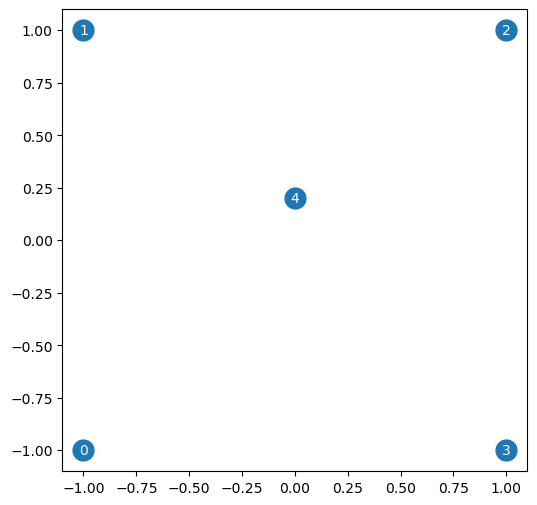

In [3]:
x,y,cities = tspSetupCoordinatesSquare(plot=True)

----
## Define distance matrix
Each point can potentially be connected with every other node. Calculates these possible distances and
collect them in a matrix `distances`.

We start calculating distances $d_{ij}$ [m] between **two** points, 
from the known coordinates of point $i$, $(x_i,y_i)$ and point $j$, $(x_j,y_j)$ [m]:
$$
d_{ij} = \sqrt{ (x_i - x_j)^2 + (y_i - y_j)^2}
$$
We collect all distance $d_{ij}$ in a matrix $\mathbb{D}$:
$$
\mathbb{D} = \left(
\begin{array}{cccc}
d_{11} & d_{12} & \dots & d_{1n} \\
d_{21} & d_{22} & \dots & d_{2n} \\
\vdots&\vdots&\vdots&\vdots\\
d_{n1} & d_{n2} & \dots & d_{nn} \\
\end{array}
\right)
$$
- Note that all distances $d_{ii}$ along the main diagonal are zero, $d_{ii}=0$,
as they connect a point with itself.
- Also note that both the distance from point 1 to 2 and from point 2 to 1 are stored.

If the discuss the distances as **road connections**, we want to mark only roads connecting
points. If there is no road between point $i$ and $i+1$, we therefore set the **non-existing**
distance to `NaN`, $d_{ij}=\text{np.nan}$.


In [4]:
def tspCreateDistanceMatrix(x,y):
    """
    create distance matrix between points
    pytagorean distance between points i and i+1
    for entries i,i (node connected to itself), distance is zero
    input:
      x,y [m] - coordinates of nodes
      N       - number of points
    output:
      matrix  - distance matrix
    """
    N = x.shape[0]
    matrix = np.zeros(N*N).reshape(N,N)
    for i in range(N):
        for j in range(N):
            matrix[i][j] = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2)
    return matrix

In [5]:
matrix = tspCreateDistanceMatrix(x,y)
print(matrix)

[[0.         2.         2.82842712 2.         1.56204994]
 [2.         0.         2.         2.82842712 1.28062485]
 [2.82842712 2.         0.         2.         1.28062485]
 [2.         2.82842712 2.         0.         1.56204994]
 [1.56204994 1.28062485 1.28062485 1.56204994 0.        ]]


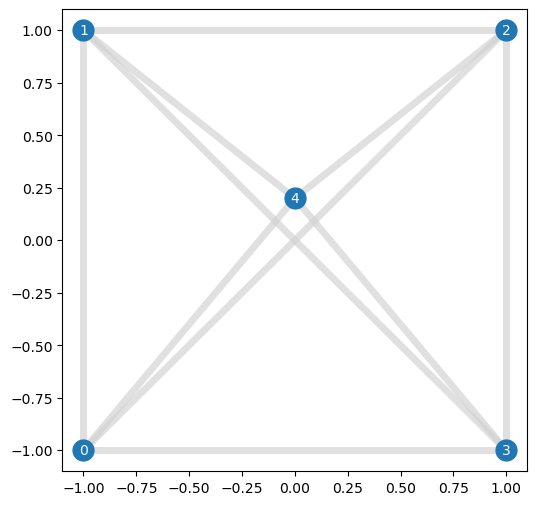

In [6]:
plt.figure(figsize=(6,6))
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])
# plot all possible distances
for i in range(matrix.shape[0]):
        for j in range(i+1,matrix.shape[0]):
            if (np.isfinite(matrix[i][j])):
                plt.plot([x[i],x[j]],[y[i],y[j]],lw=5,alpha=0.7,color='lightgray')
# plot nodes
plt.plot(x,y,lw=0,marker='o',markersize=15)
for i in range(len(x)):
    plt.text(x[i],y[i],str(cities[i]),ha='center',va='center',color=(1,1,1))

We observe that there are connections beween nodes 1 and 3 and 0 and 2, which bypass 4.
Thiunking in terms of roads, this would mean 1-3 and 0-4 are no rads and need to be
excluded:

In [7]:
matrix2 = np.copy(matrix)
matrix2[0][2] = np.nan
matrix2[2][0] = np.nan
matrix2[1][3] = np.nan
matrix2[3][1] = np.nan
print(matrix2)

[[0.         2.                nan 2.         1.56204994]
 [2.         0.         2.                nan 1.28062485]
 [       nan 2.         0.         2.         1.28062485]
 [2.                nan 2.         0.         1.56204994]
 [1.56204994 1.28062485 1.28062485 1.56204994 0.        ]]


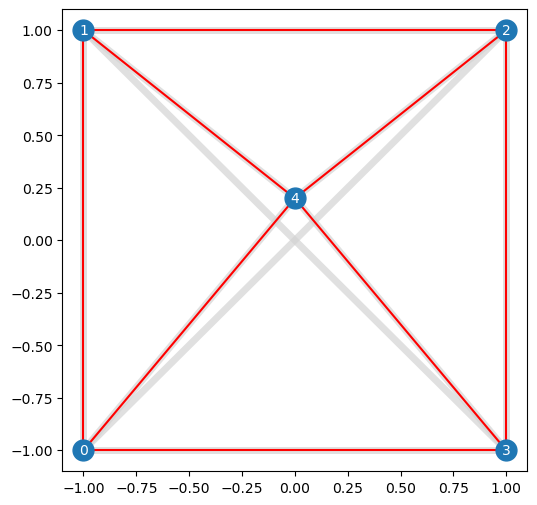

In [8]:
plt.figure(figsize=(6,6))
plt.xlim([-1.1,1.1])
plt.ylim([-1.1,1.1])


# plot all possible distances
for i in range(matrix.shape[0]):
        for j in range(i+1,matrix.shape[0]):
            if (np.isfinite(matrix[i][j])):
                plt.plot([x[i],x[j]],[y[i],y[j]],lw=5,alpha=0.7,color='lightgray')
# plot manually allowed distances
for i in range(matrix2.shape[0]):
        for j in range(i+1,matrix2.shape[0]):
            if (np.isfinite(matrix2[i][j])):
                plt.plot([x[i],x[j]],[y[i],y[j]],lw=1.5,color='red')
# plot nodes
plt.plot(x,y,lw=0,marker='o',markersize=15)
for i in range(len(x)):
    plt.text(x[i],y[i],str(cities[i]),ha='center',va='center',color=(1,1,1))

Next, we want to identify the **shortest path** connecting all nodes once ...

----